In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import utilities.plotting_utilities

from initial_states.parallelclifford import ParallelCliffordLoader
from initial_states.pyramidclifford import PyramidCliffordLoader
from initial_states.sparseclifford import SparseCliffordLoader

In [2]:
# name = "complete_graph"
name = "barbell_graph"

if name == "complete_graph":
    G = nx.complete_graph(4)
    pos = {}
    pos[0] = [0,0]
    pos[1] = [0.5,1]
    pos[2] = [1,0]
    pos[3] = [0.5,1/3]
    pos[4] = [0.8,0]

elif name== "barbell_graph":
    G = nx.barbell_graph(3, 0)
    pos = {}
    pos[0] = [0,0]
    pos[1] = [0,1]
    pos[2] = [1,0.5]
    pos[3] = [2,0.5]
    pos[4] = [3,0]
    pos[5] = [3,1]

root degree 2.0
number of STs 9.000000000000002


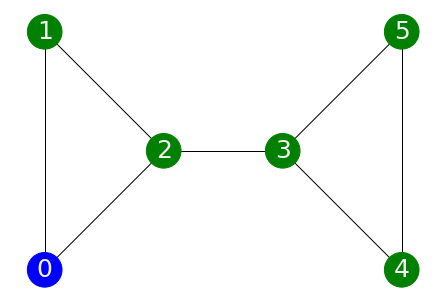

In [3]:
G = nx.convert_node_labels_to_integers(G)  
B = nx.incidence_matrix(G, oriented=True).todense().T
# root = 3
root =  0
b = B[:,root]
print('root degree',np.sum(b*b, axis=0))
X = np.delete(B, root, 1) # remove col of root
W = X / np.sqrt(np.sum(X*X, axis=0)) 


rank = X.shape[1]
# number of STs
print("number of STs",np.linalg.det(X.T@X))
color_map = []
for node in G:
    if node == root:
        color_map.append('blue')
    else: 
        color_map.append('green')   
# nx.draw(G, node_color=color_map, with_labels = True,font_size=25,node_size=1200, font_color="whitesmoke")
nx.draw(G, pos=pos, node_color=color_map, with_labels = True,font_size=25,node_size=1200, font_color="whitesmoke")
# nx.write_latex(G, name*".tex", pos=pos, as_document=True)

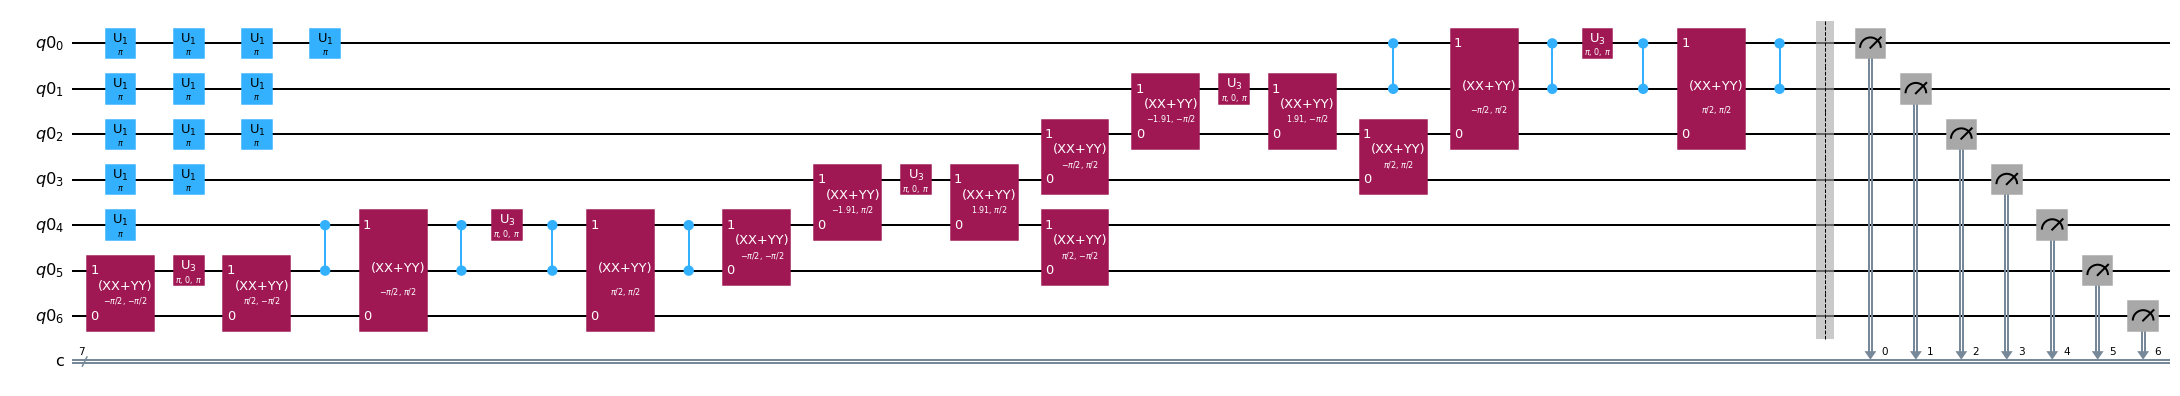

In [ ]:
n = W.shape[0] # number of edges

# circuit = ParallelCliffordLoader(W) # (with FBS gates)
circuit = SparseCliffordLoader(W) # (with FBS gates)
# circuit = PyramidCliffordLoader(W) # (with only RBS gates)

# Add measurements
meas = qk.QuantumCircuit(n, n) # n qubits, n classical bits
meas.barrier(range(n)) # the barrier is optional, it is an instruction for the later transpiler
meas.measure(range(n), range(n)) # perform the measurement, record it in the classical bits
circuit.add_register(meas.cregs[0])
qc = circuit.compose(meas)
# drawing
qc.decompose().draw(
    output="mpl", 
    filename="fig/example_circuit.pdf",
    scale = 1,
    fold=300)

In [5]:
# n = W.shape[0] # number of edges
# # W, _ = np.linalg.qr(W)
# circuit = ParallelCliffordLoader(W) # (with FBS gates)
# # circuit = PyramidCliffordLoader(W) # (with RBS gates)
# circuit.measure_all()

### Simulations

In [6]:
max_cardinality = 10

# Import Aer and set the backend simulator
from qiskit_aer import Aer
# can also select largest sample cardinal to be examined
backend_sim = Aer.get_backend('qasm_simulator')
# Execute the circuit on the qasm simulator, we do several repeats to get 
# the distribution of the TV between the empirical measure and the underlying DPP.
tv_distances = []
num_repeats = 100 # 1000
num_shots = 1000 #20000
proba = {} # add empty set for compatibility with empty IBM measurements
proba_estimated = {}
for _ in range(num_repeats):
    job_sim = backend_sim.run(
        qk.transpile(qc, backend_sim), 
        shots=num_shots
    )
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc)
    proba, proba_estimated = utilities.plotting_utilities.get_estimated_probabilities_skew_cutoff(W,max_cardinality, counts, num_shots)
    tv_distances.append(
        0.5*np.sum([np.abs(proba[key]-proba_estimated[key]) for key in proba])
    )

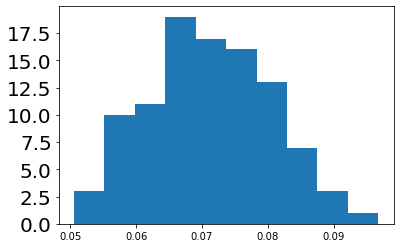

In [7]:
# obtained by using a cutoff on sample size
plt.hist(tv_distances)
plt.xticks(fontsize=10)
# plt.xticks([0.004, 0.006, 0.010, 0.014])
plt.yticks(fontsize=20)
plt.xticks()
plt.savefig("fig/dpp1_tv.pdf")
plt.show()

<AxesSubplot:xlabel='outcome'>

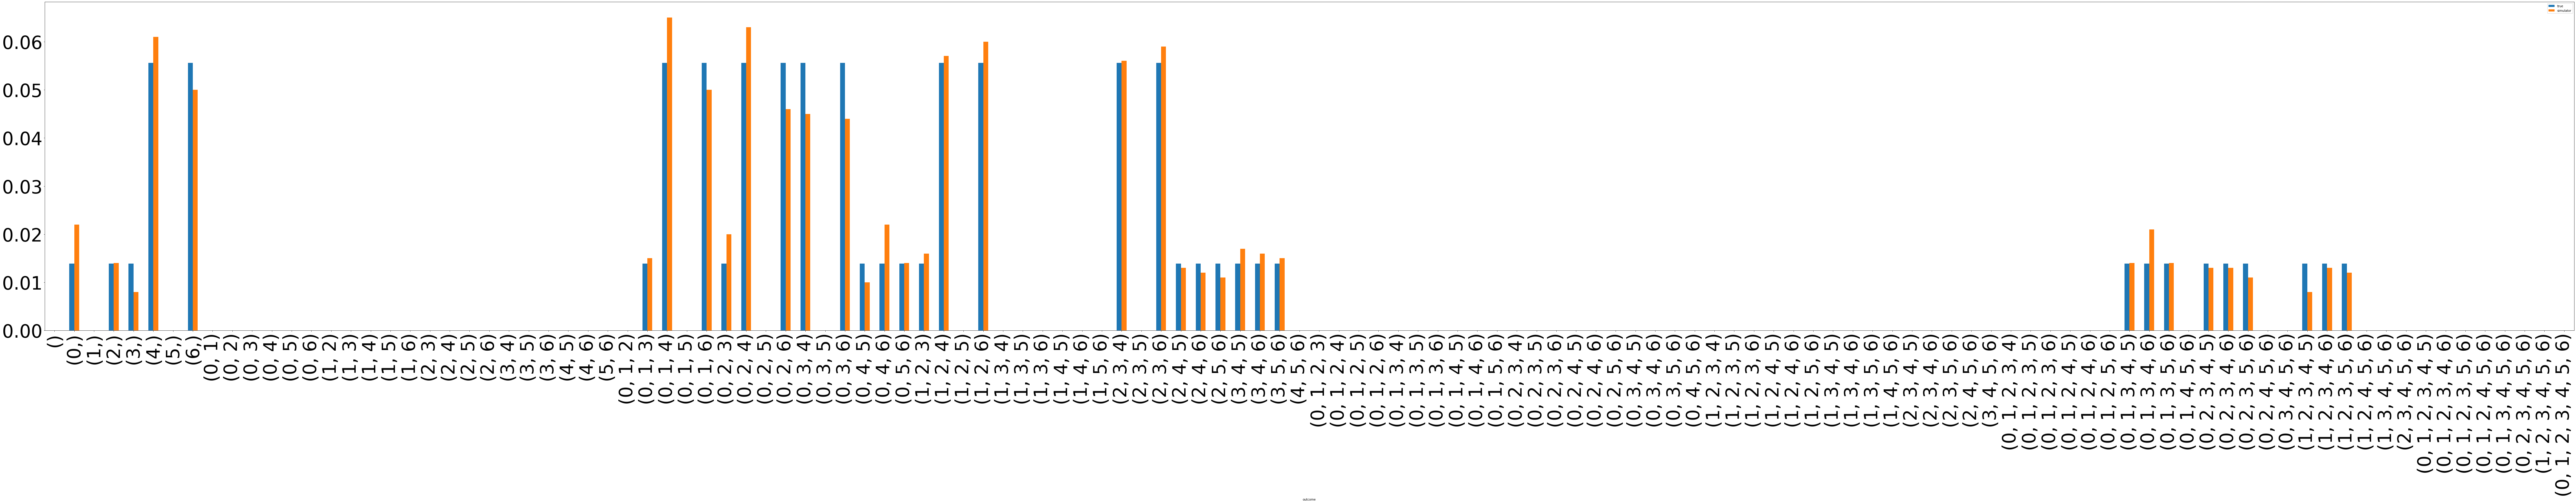

In [8]:
# obtained by using a cutoff on sample size
proba_series = pd.Series(proba.values(), index=list(proba.keys()), name="true")
proba_estimated_series = pd.Series(proba_estimated.values(), index=list(proba_estimated.keys()), name="simulator")
proba_series.index.name = "outcome"
proba_estimated_series.index.name = "outcome"
df = pd.merge(proba_series, proba_estimated_series, on="outcome")
df.plot.bar(figsize=(150,20), fontsize = 60)

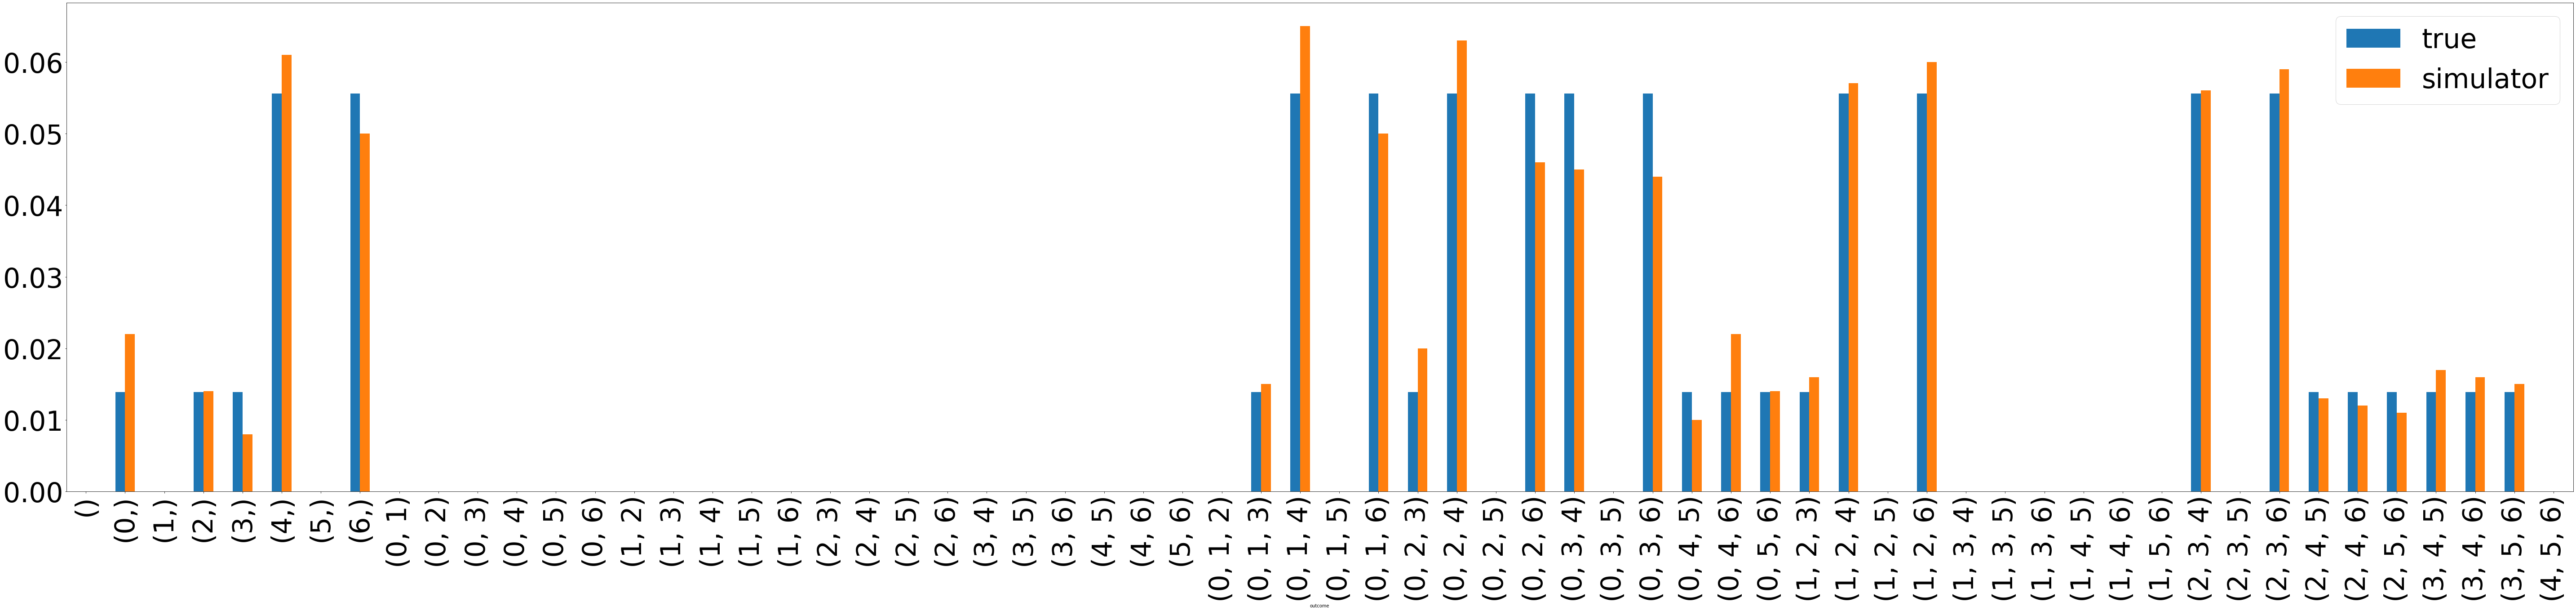

In [9]:
proba_smaller_than_3 = {}
proba_estimated_smaller_than_3 = {}
proba_larger_than_3 = {}
proba_estimated_larger_than_3 = {}

for key in proba:
    if len(key) < 4:
        proba_smaller_than_3[key] = proba[key]
        proba_estimated_smaller_than_3[key] = proba_estimated[key]
    else:
        proba_larger_than_3[key] = proba[key]
        proba_estimated_larger_than_3[key] = proba_estimated[key]

proba_series_smaller_than_3 = pd.Series(proba_smaller_than_3.values(), index=list(proba_smaller_than_3.keys()), name="true")
proba_estimated_series_smaller_than_3 = pd.Series(proba_estimated_smaller_than_3.values(), index=list(proba_estimated_smaller_than_3.keys()), name="simulator")
proba_series_smaller_than_3.index.name = "outcome"
proba_estimated_series_smaller_than_3.index.name = "outcome"
df = pd.merge(proba_series_smaller_than_3, proba_estimated_series_smaller_than_3, on="outcome")
df.plot.bar(figsize=(100,20), fontsize = 60).legend(fontsize=60,loc='best')

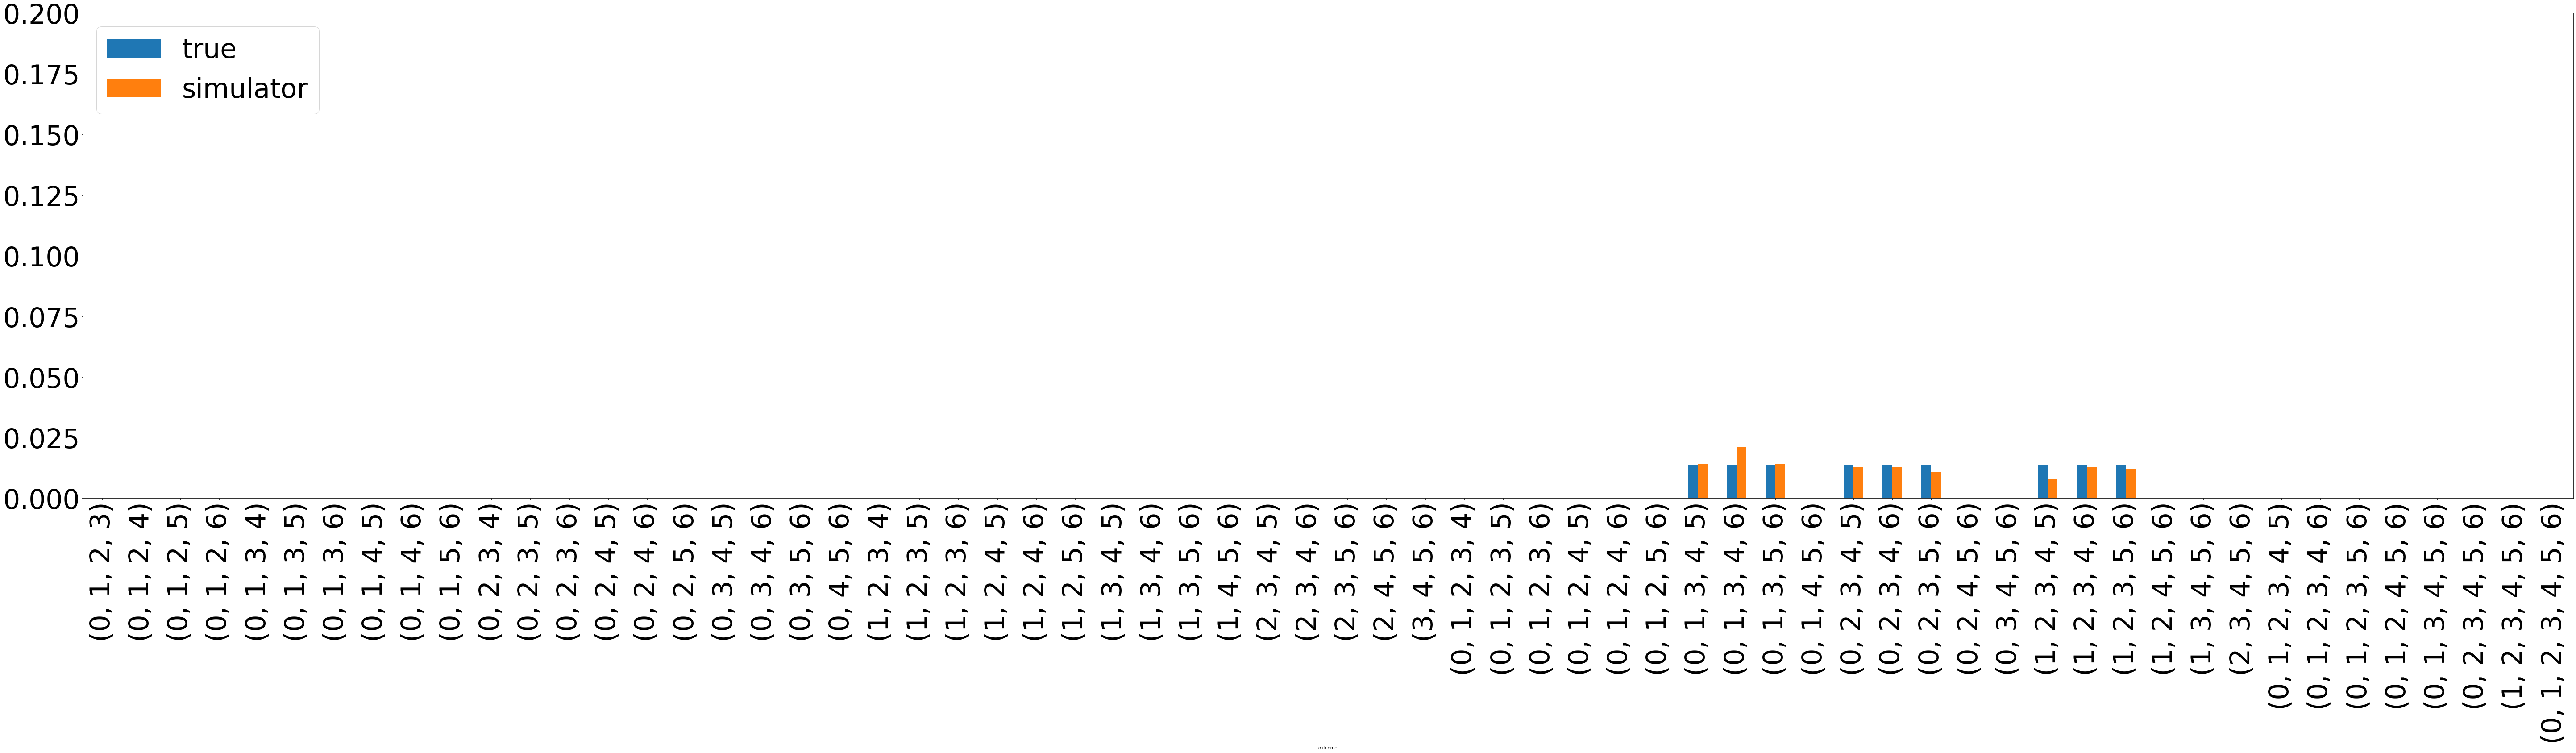

In [10]:
proba_series_larger_than_3 = pd.Series(proba_larger_than_3.values(), index=list(proba_larger_than_3.keys()), name="true")
proba_estimated_series_larger_than_3 = pd.Series(proba_estimated_larger_than_3.values(), index=list(proba_estimated_larger_than_3.keys()), name="simulator")
proba_series_larger_than_3.index.name = "outcome"
proba_estimated_series_larger_than_3.index.name = "outcome"
df = pd.merge(proba_series_larger_than_3, proba_estimated_series_larger_than_3, on="outcome")
df.plot.bar(figsize=(100,20), fontsize = 60,ylim = [0,0.2]).legend(fontsize=60, loc="upper left")
# ax.set_ylim([0,1])

In [11]:
from scipy.stats import chisquare
# normalize frequencies to prepare the test
f_exp = np.array(list(proba.values()))
f_exp = f_exp/sum(f_exp)
f_obs =  np.array(list(proba_estimated.values()))
f_obs = f_obs/sum(f_obs)

# remove the zero entries
f_exp[np.abs(f_exp)< 1e-6] = 0
f_exp = np.ma.masked_equal(f_exp,0)
f_exp = f_exp.compressed()

f_obs[np.abs(f_obs)< 1e-6] = 0
f_obs = np.ma.masked_equal(f_obs,0)
f_obs =f_obs.compressed()

chisquare(f_obs=f_obs, f_exp=f_exp)

Power_divergenceResult(statistic=0.036260000000000035, pvalue=1.0)

### Amplitude amplification

In [12]:
import math
m_max = 5

acceptance_probability = np.zeros((m_max + 1,))
W = X / np.sqrt(np.sum(X*X, axis=0)) 
a = np.linalg.det(W.T@W)
theta_a = math.asin(math.sqrt(a))

for m in range(0,m_max + 1):
    acceptance_probability[m] = (math.sin((2*m+1)*theta_a))**2

In [13]:
def count_nb_accepted(samples,rank):
    num_shots = samples.shape[0]
    nb_accepted = 0.
    for nb in range(0,num_shots):
        nb_ones = int(np.sum(samples[nb,:]))
        if nb_ones == rank:
            nb_accepted = nb_accepted + 1
    return int(nb_accepted)

In [14]:
from utilities.circuits_amplitude_amplification import sample_Clifford_circuit

num_shots = 50
n_rep = 3

acceptance_frequency = np.zeros((n_rep,m_max+1))
for m_Grover in range(0,m_max + 1):
    print("m_Grover = ", m_Grover)
    for rep in range(0,n_rep):
        samples = sample_Clifford_circuit(X,num_shots,m_Grover)
        nb_accepted = count_nb_accepted(samples,rank)
        frq = nb_accepted / num_shots
        acceptance_frequency[rep,m_Grover] = frq

m_Grover =  0
m_Grover =  1
m_Grover =  2
m_Grover =  3
m_Grover =  4
m_Grover =  5


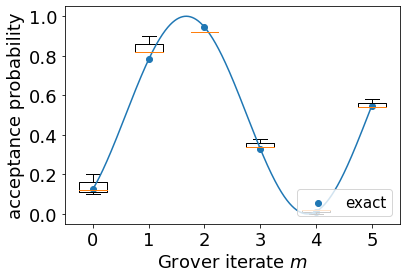

In [15]:
labels = [ str(x) for x in np.array(range(0,m_max + 1))]
plt.boxplot(acceptance_frequency,positions =np.array(range(0,m_max + 1)))
plt.scatter(np.array(range(0,m_max + 1)),acceptance_probability, label="exact")
x =np.linspace(0, m_max, 1000)
y = (np.sin((2*x+1)*theta_a))**2
plt.plot(x,y)
plt.xlabel('Grover iterate $m$', fontsize = 18)
plt.ylabel('acceptance probability', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xticks(np.array(range(0,m_max + 1)),labels)
plt.legend(loc="lower right", fontsize = 15)
plt.show()

In [16]:
# # number of applications of Q (Grover's operator)
# m = 0
# num_shots = 1
# samples = sample_Clifford_circuit(X,num_shots,m)
# sample_DPP = samples[0,:]
# print("number of edges in sample: ", sample_DPP.sum())

# n_nodes = G.number_of_nodes()
# G_sp = nx.empty_graph(n_nodes)
# it = 0
# for e in G.edges:
#     if sample_DPP[it] == 1:
#         G_sp.add_edge(e[0],e[1])
#     it = it + 1
    
# nx.draw(G_sp, pos=pos, node_color=color_map , with_labels = True,font_size=20,node_size=500)